In [3]:
x = '/cluster2/home/Kangwen/0_benchmark/0_benchmark_dataset/8_scNano/data/SRR22179631_P36B2_GM12878-medium.pairs.gz'

'GM12878-medium'

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from fasthigashi.FastHigashi_Wrapper import *

In [4]:
from higashi2.Higashi_wrapper import *
config = "/cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_500k/config_ckw.JSON"
higashi_model = Higashi(config)

In [5]:
higashi_model.process_data()

generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/389 [00:00<?, ?it/s]

generating contact maps for baseline
data loaded
31004372 False
chr2 split_num 1


creating matrices tasks:   0%|          | 0/22 [00:00<?, ?it/s]

total_feats_size 252


  0%|          | 0/22 [00:00<?, ?it/s]

In [6]:
import pickle
import numpy as np
filelist = pd.read_csv(higashi_model.config['data_dir'] + '/filelist.txt',header=None)
nums = filelist.shape[0]
label_info = {'name': np.arange(nums ),
              'lb': np.array([x.split('/')[-1].split('_')[-1].split('.')[0] for x in filelist[0]]),
              }

pickle.dump(label_info, open(higashi_model.config['data_dir'] + "/label_info.pickle", "wb"))

In [7]:
fh_model = FastHigashi(config_path=config,
                    path2input_cache="/cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_50k",
                    path2result_dir="/cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_50k",
                    off_diag=100, # 0-100th diag of the contact maps would be used.
                    filter=False, # fit the model on high quality cells, transform the rest
                    do_conv=False,# linear convolution imputation
                    do_rwr=False, # partial random walk with restart imputation
                    do_col=False, # sqrt_vc normalization
                    no_col=False) # force to not do sqrt_vc normalization

setting to gpu:0 available memory = 65319 MB


In [8]:
# Pack from sparse mtx to tensors
fh_model.prep_dataset()

total number of cells that pass qc check 387 bad 2 total: 389
cache file = /cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_50k/cache_intra_500000_offdiag_100_.pkl
saving cached input to /cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_50k/cache_intra_500000_offdiag_100_.pkl


sparse mtx into tensors:   0%|          | 0/22 [00:00<?, ?it/s]

breaking into batches:   0%|          | 0/22 [00:00<?, ?it/s]

sparsity 0.07809693062939019
do_conv False do_rwr False do_col False
recommend_bs_cell [389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389] pinning memory


In [9]:
fh_model.run_model(dim1=.6,
                rank=256,
                n_iter_parafac=1,
                extra="")

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
empty params initialized
time elapsed: 0.04


initializing params:   0%|          | 0/22 [00:00<?, ?it/s]

rwr iters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
time elapsed: 53.56
finish init
Starting iteration 0

PARAFAC2 re=5.799 takes 27.0s
Starting iteration 1

PARAFAC2 re=0.296 9.97e-01 variation min9.8e-01 at chrom 21, max1.0e+00 at chrom 1 takes 26.5s
Starting iteration 2

PARAFAC2 re=0.269 1.70e-01 variation min7.6e-02 at chrom 4, max4.8e-01 at chrom 21 takes 29.9s
Starting iteration 3

PARAFAC2 re=0.253 1.18e-01 variation min6.4e-02 at chrom 12, max1.8e-01 at chrom 6 takes 26.6s
Starting iteration 4

PARAFAC2 re=0.238 1.15e-01 variation min5.9e-02 at chrom 21, max1.7e-01 at chrom 0 takes 25.8s
Starting iteration 5

PARAFAC2 re=0.229 7.47e-02 variation min3.7e-02 at chrom 21, max1.1e-01 at chrom 1 takes 23.5s
Starting iteration 6

PARAFAC2 re=0.224 3.97e-02 variation min2.0e-02 at chrom 21, max6.1e-02 at chrom 4 takes 12.8s
Starting iteration 7

PARAFAC2 re=0.222 2.17e-02 variation min1.1e-02 at chrom 20, max3.6e-02 at chrom 4 takes 11.2s
Starting iteration 8

PARAFAC2 re=0.220 

In [20]:
cell_embeddings = fh_model.fetch_cell_embedding(final_dim=256)['embed_all']

fetching embedding


In [19]:
print (cell_embeddings.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


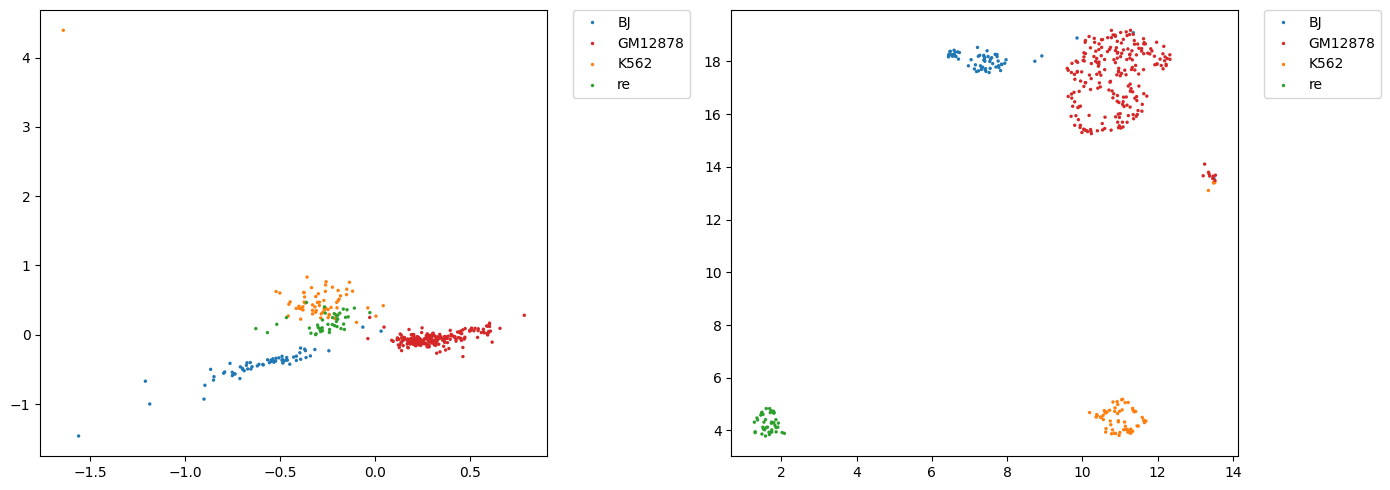

In [21]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
cell_type = fh_model.label_info['lb']
fig = plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
vec = PCA(n_components=2).fit_transform(cell_embeddings)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=cell_type, ax=ax, s=6, linewidth=0)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax = plt.subplot(1, 2, 2)
vec = UMAP(n_components=2).fit_transform(cell_embeddings)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=cell_type, ax=ax, s=6, linewidth=0)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.savefig("fasthigashi_embedding.png")
plt.show()

{'data_dir': '/cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_500k',
 'structured': True,
 'input_format': 'higashi_v2',
 'header_included': True,
 'temp_dir': '/cluster/home/Kangwen/dream/re_fasthigashi/LiMAC_500k',
 'genome_reference_path': '/cluster/home/Kangwen/common/hg38/hg38.fa.chrom.sizes',
 'cytoband_path': '/cluster/home/Kangwen/dream/re_higashi/test1/cytoBand_hg38.txt',
 'chrom_list': ['chr1',
  'chr2',
  'chr3',
  'chr4',
  'chr5',
  'chr6',
  'chr7',
  'chr8',
  'chr9',
  'chr10',
  'chr11',
  'chr12',
  'chr13',
  'chr14',
  'chr15',
  'chr16',
  'chr17',
  'chr18',
  'chr19',
  'chr20',
  'chr21',
  'chr22'],
 'resolution': 500000,
 'resolution_cell': 500000,
 'resolution_fh': [500000],
 'embedding_name': 'test',
 'minimum_distance': 500000,
 'maximum_distance': -1,
 'local_transfer_range': 0,
 'loss_mode': 'zinb',
 'dimensions': 128,
 'impute_list': ['chr1',
  'chr2',
  'chr3',
  'chr4',
  'chr5',
  'chr6',
  'chr7',
  'chr8',
  'chr9',
  'chr10',
  'chr11',
  'chr12',